<a href="https://colab.research.google.com/github/gowthambalachandhiran/VisualQuestionAnswering/blob/master/VQAPred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install keras==2.1.0

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import keras
import os, argparse
import cv2, spacy, numpy as np
from keras.layers import Input, LSTM, Embedding, Dense
from keras.applications.vgg16 import VGG16
from keras.models import model_from_json
from keras.optimizers import SGD
from sklearn.externals import joblib
from keras import backend as K
from keras.utils.vis_utils import plot_model
K.set_image_data_format('channels_first')
import csv

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
def get_image_model_without():
    ''' Takes the CNN weights file, and returns the VGG model update 
    with the weights. Requires the file VGG.py inside models/CNN '''
    image_model = VGG16(weights='imagenet', include_top=False)
    image_model.layers.pop()
    image_model.layers.pop()
    # this is standard VGG 16 without the last two layers
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    # one may experiment with "adam" optimizer, but the loss function for
    # this kind of task is pretty standard
    image_model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return image_model

In [4]:
vgg_without = get_image_model_without()











58892288/58889256 [==============================] - 1s 0us/step

Instructions for updating:
keep_dims is deprecated, use keepdims instead



In [4]:
!python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [0]:
def get_question_features_without_fd(question):
    ''' For a given question, a unicode string, returns the time series vector
    with each word (token) transformed into a 300 dimension representation
    calculated using Glove Vector '''
    word_embeddings = spacy.load('en_core_web_md')
    tokens = word_embeddings(question)
    question_tensor = np.zeros((30, 300))
    for j in range(len(tokens)):
        question_tensor[j,:] = tokens[j].vector
    return question_tensor

In [0]:
from keras.preprocessing import image
from keras.applications import vgg16
from keras.models import Model

In [0]:
def get_image_features_without_fd(image_file_name):
    ''' Runs the given image_file to VGG 16 model and returns the 
    weights (filters) as a 1, 4096 dimension vector '''
    img = image.load_img(image_file_name, target_size=(224, 224))
    model = vgg16.VGG16(weights='imagenet', include_top=True)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    model_extractfeatures = Model(input=model.input, output=model.get_layer('fc2').output)
    fc2_features = model_extractfeatures.predict(x)
    image_features = fc2_features.reshape((4096,1))
    return image_features

In [0]:
def get_VQA_model():
    ''' Given the VQA model and its weights, compiles and returns the model '''

    # thanks the keras function for loading a model from JSON, this becomes
    # very easy to understand and work. Alternative would be to load model
    # from binary like cPickle but then model would be obfuscated to users
    vqa_model = model_from_json(open("/content/model/our_model_final.json").read())
    # vqa_model.load_weights(VQA_weights_file_name)
    vqa_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return vqa_model

In [9]:
our_vqa_model = get_VQA_model()
our_vqa_model.summary()




Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_2 (Merge)              (None, 4608)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              4719616   
_________________________________________________________________
activation_5 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_6 (A

In [10]:
!python -m spacy download en_core_web_md


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [11]:
training_datas = []
with open('/content/CSV/training.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  for row in csv_reader:
    training_datas.append(row)
training_datas = training_datas[1:]
len(training_datas)

56

In [12]:
print(training_datas)

[['1', 'is this xray', 'yes'], ['2', 'Does this image has single or multiple facture', 'single'], ['3', 'Does this image have single or multiple facture', 'multiple'], ['4', 'is this xray showing foreign body', 'foreign'], ['5', 'is this xray', 'yes'], ['6', 'foreign body oresent', 'foreign'], ['7', 'what is the body part in xray', 'hand'], ['8', 'what is the body part in xray', 'skull'], ['9', 'what is the body part in xray', 'skull'], ['10', 'what is the body part in xray', 'skull'], ['11', 'what is the body part in xray', 'skull'], ['12', 'what is the body part in xray', 'hand'], ['13', 'is this left or righ hand', 'left'], ['14', 'is this left or righ hand', 'left'], ['15', 'is this left or righ hand', 'right'], ['16', 'is this left or righ hand', 'left'], ['17', 'is this left or righ hand', 'right'], ['18', 'is this left or righ hand', 'right'], ['19', 'is this left or righ hand', 'right'], ['20', 'is this left or righ hand', 'right'], ['21', 'is this left or righ hand', 'left'], 

In [0]:
from keras.applications.vgg16 import preprocess_input

In [14]:

trainX= []
for training_data in training_datas:
  img_id,text,output = training_data
  print("Processing {} image".format(img_id))
  image_features = get_image_features_without_fd("/content/Images/{}.jpg".format(img_id))
  question_features = get_question_features_without_fd(text)
  trainX.append([question_features,image_features])
np.array(trainX).shape

Processing 1 image







Instructions for updating:
keep_dims is deprecated, use keepdims instead
Processing 2 image
Processing 3 image
Processing 4 image
Processing 5 image
Processing 6 image
Processing 7 image
Processing 8 image
Processing 9 image
Processing 10 image
Processing 11 image
Processing 12 image
Processing 13 image
Processing 14 image
Processing 15 image
Processing 16 image
Processing 17 image
Processing 18 image
Processing 19 image
Processing 20 image
Processing 21 image
Processing 22 image
Processing 23 image
Processing 24 image
Processing 25 image
Processing 26 image
Processing 27 image
Processing 28 image
Processing 29 image
Processing 30 image
Processing 31 image
Processing 32 image
Processing 33 image
Processing 34 image
Processing 35 image
Processing 36 image
Processing 37 image
Processing 38 image
Processing 39 image
Processing 40 image
Processing 41 image
Processing 42 image
Processing 43 image
Processing 45 image
Processing 46 image
Processing 47 image
Processin

(56, 2)

In [15]:
import numpy as np
np.array(trainX).shape

(56, 2)

In [0]:
question_features_array = []
image_features_array = []
for x in trainX:
  question_features_array.append(x[0])
  image_features_array.append(x[1])

In [30]:
question_features_array = np.array(question_features_array)
#image reshape to accomadate deep learning model
image_features_array = np.array(image_features_array).reshape(56, 4096)
print(question_features_array.shape)
print(image_features_array.shape)

(56, 30, 300)
(56, 4096)


In [31]:
trainY= []
for training_data in training_datas:
  img_id,text,output = training_data
  trainY.append(output)
print(len(trainY))
print(trainY)

56
['yes', 'single', 'multiple', 'foreign', 'yes', 'foreign', 'hand', 'skull', 'skull', 'skull', 'skull', 'hand', 'left', 'left', 'right', 'left', 'right', 'right', 'right', 'right', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left', 'yes', 'yes', 'foreign', 'foreign', 'foreign', 'foreign', 'foreign', 'leg', 'leg', 'leg', 'leg', 'leg', 'leg', 'leg', 'multiple', 'multiple', 'multiple', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes']


In [32]:
set_trainy = list(set(trainY))
trainY_labels = []
for y in trainY:
  trainY_labels.append(set_trainy.index(y))
print(trainY_labels)

[6, 2, 7, 9, 6, 9, 1, 4, 4, 4, 4, 1, 5, 5, 0, 5, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 9, 9, 9, 9, 9, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6]


In [0]:
trainY_cate = keras.utils.to_categorical(trainY_labels, num_classes=10)

In [35]:
history = our_vqa_model.fit([question_features_array,image_features_array],trainY_cate,5,30)

Epoch 1/30
56/56 [==============================] - 5s 82ms/step - loss: 0.3371
Epoch 2/30
56/56 [==============================] - 4s 77ms/step - loss: 0.4925
Epoch 3/30
56/56 [==============================] - 4s 72ms/step - loss: 0.1901
Epoch 4/30
56/56 [==============================] - 4s 68ms/step - loss: 0.2947
Epoch 5/30
56/56 [==============================] - 4s 73ms/step - loss: 0.1340
Epoch 6/30
56/56 [==============================] - 4s 70ms/step - loss: 0.1587
Epoch 7/30
56/56 [==============================] - 4s 76ms/step - loss: 0.2768
Epoch 8/30
56/56 [==============================] - 4s 78ms/step - loss: 0.1748
Epoch 9/30
56/56 [==============================] - 4s 76ms/step - loss: 0.1212
Epoch 10/30
56/56 [==============================] - 4s 77ms/step - loss: 0.2331
Epoch 11/30
56/56 [==============================] - 4s 69ms/step - loss: 0.0837
Epoch 12/30
56/56 [==============================] - 4s 78ms/step - loss: 0.1079
Epoch 13/30
56/56 [==================

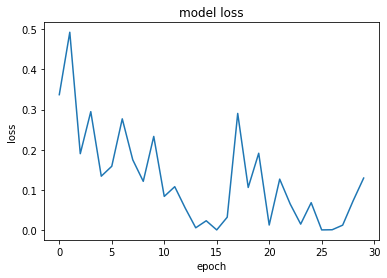

In [41]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


In [47]:
our_vqa_model.predict_classes([question_features_array[0:1],image_features_array[0:1]])

1/1 [==============================] - 0s 32ms/step


array([0])

In [57]:
image_features_array[0:1].shape

(1, 4096)

In [45]:
our_vqa_model.predict([question_features_array[0:1],image_features_array[0:1]])

array([[9.99886990e-01, 1.10582118e-06, 6.00853634e-09, 5.70172993e-08,
        6.24024636e-08, 1.42820165e-08, 1.10899266e-04, 7.82629378e-11,
        3.49850495e-08, 8.05331752e-07]], dtype=float32)

In [0]:
def convert_questions_features(text):
  word_embeddings = spacy.load('en_core_web_md')
  tokens = word_embeddings(text)
  question_tensor = np.zeros((30, 300))
  for j in range(len(tokens)):
    question_tensor[j,:] = tokens[j].vector
  question_tensor = np.array(question_tensor)
  return question_tensor



In [0]:
def covert_image_features(image_path):
  image_features = get_image_features_without_fd(image_path)
  image_features = np.array(image_features_array).reshape(56, 4096)
  return image_features



In [54]:
covert_image_features('/content/Images/1.jpg').shape

(56, 4096)

In [58]:
our_vqa_model.predict_classes([convert_questions_features("is this xray").reshape(1,30,300),covert_image_features('/content/Images/1.jpg').reshape(1,4096)])

ValueError: ignored